### **NYC Property Sales Dataset - Jupyter Notebook** 

### Preprocessing

#### Library Imports

In [228]:
# Cell for library imports
import os
import re

import numpy as np
import pandas as pd
import datetime as dt

#Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Warning suppression
import warnings
warnings.filterwarnings("ignore")

#### Jupyter Notebook Parameters

In [229]:
# Jupyter notebook settings

# Display all columns in the dataframe
pd.set_option('display.max_columns', None)

#Inline graphs for matplotlib
%matplotlib inline
# Set default font size for matplotlib
plt.rcParams['font.size'] = 14

# Set the default style for seaborn
sns.set_style("whitegrid")
#Set the default color palette for seaborn
sns.set_palette("deep")


#### Dataset examination
- Examination of 2 datasets to identify cleaning requirements

In [230]:
# Import NYC Property Sales Dataset over 2 periods (Manhattan) for inspection and dataset cleaning requirement identification
# Sales for Manhattan in 2023
man_23 = pd.read_excel('./raw_data/2023_manhattan.xlsx')
man_23.head()

,MANHATTAN ANNUAL SALES FOR CALENDAR YEAR 2023,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20
0,All Sales From January 2023- December 2023. Pr...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"For sales prior to the Final, Neighborhood Nam...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"Sales after the Final Roll, Neighborhood Name ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Building Class Category is based on Building C...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Note: Condominium and cooperative sales are on...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [231]:
#Sales for Manhattan in 2024
man_24 = pd.read_excel('./raw_data/rollingsales_bronx_24.xlsx')
man_24.head()

,Bronx Rolling Sales. All Sales From March 2024 - February 2025,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,PTS Sales Data as of 03/06/2025,Unnamed: 20
0,"For sales prior to the Final Roll, Neighborhoo...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Building Class Category is based on Building C...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Note: Condominium and cooperative sales are on...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASEMENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
4,2,BATHGATE,01 ONE FAMILY DWELLINGS,1,2907,24,NaN,A1,4090 PARK AVENUE,NaN,10457,1,0,1,2500,1474,1901,1,A1,0,2024-03-28 00:00:00


There are several issues within the dataset which require cleaning and preprocessing upon inspection both within pandas and excel which appear to be consistent across datasets across the years. 

This includes:

**Column Headers and row index at start of dataset**
- Rows from index 0-4 (5 rows) and 6 (1 row) are dropped (Column header in row index 5) for year 2023. However this is not consistent between the years. Indexing the header using loc will thus not work uniformly.
- For consistency purposes the first 10 rows will be dropped and the original headers will be added before further processing 
- Columns names to be formatted where double spaces and new lines are to be replaced with single space

**Data Type**
- Numerical data columns of object type to be converted to interger (Block, Lot, ZIP etc.)
- Categorical data columns of object type to be converted to string (Building Class Category, Address)
- Sale date column are converted to datetime format (YYYY-MM-DD)
 
**Missing Value Treatment**
- Sale price of 0, 1 and other arbitrary low number are to be replaced with NaN as this generally indicates a transfer of ownership per appendix. For data quality purposes sale prices from 0-10000 will be NaN.

**Dropping of Columns and Records**
- Block/lot/ease-ment are used for tax purpsoes and does not affect sales
- A significant percentage (in excess of 60%) of land/gross square feet values are missing. While these variables are useful in identifying average cost per area, for scope and accuracy purposes will not be considered
- Building class at present and time of sale are not relevant to sales and are to be removed


**Treatment of Records**
- Per appendix, transactions with Tax Class 4 are that of commercial properties. These typically have a high transactional sale above residential properties and are to be removed to prevent skewing
-Borough numbers are to be renamed to as per respective NYC Borough Code reference where: 


| Code | Borough Name   |
|------|----------------|
| 1    | Manhattan      |
| 2    | Bronx          |
| 3    | Brooklyn       |
| 4    | Queens         |
| 5    | Staten Island  |

For ease of processing multiple datasets, a function (load_clean_data) will be created to address the above.



In [232]:
def load_clean_data(filepath):
    
    # Define expected column names manually (from the 2023/2024 files)
    columns = [
        'BOROUGH', 'NEIGHBORHOOD', 'BUILDING CLASS CATEGORY', 'TAX CLASS AT PRESENT',
        'BLOCK', 'LOT', 'EASE-MENT', 'BUILDING CLASS AT PRESENT', 'ADDRESS',
        'APARTMENT NUMBER', 'ZIP CODE', 'RESIDENTIAL UNITS', 'COMMERCIAL UNITS',
        'TOTAL UNITS', 'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'YEAR BUILT',
        'TAX CLASS AT TIME OF SALE', 'BUILDING CLASS AT TIME OF SALE',
        'SALE PRICE', 'SALE DATE'
    ]
    
    # Load dataset, skipping the first 6 rows
    df = pd.read_excel(filepath, skiprows=10, header=None)
    
    # Drop the first row (which is often empty or misaligned), reset index
    df = df.iloc[1:].reset_index(drop=True)
    
    # Assign column names manually
    df.columns = columns[:len(df.columns)]
    
    # Clean column names
    df.columns = (
        df.columns.str.strip()
                  .str.replace('\n', ' ', regex=True)
                  .str.replace('\s+', ' ', regex=True)
    )
    
    # Replace borough numbers with names
    borough_map = {
        1: 'MANHATTAN', 2: 'BRONX', 3: 'BROOKLYN', 4: 'QUEENS', 5: 'STATEN ISLAND'
    }
    df['BOROUGH'] = pd.to_numeric(df['BOROUGH'], errors='coerce').map(borough_map)
    
    # Drop unnecessary columns
    columns_to_drop = [
        'BLOCK', 'LOT', 'EASE-MENT', 'BUILDING CLASS AT TIME OF SALE',
        'BUILDING CLASS AT PRESENT', 'APARTMENT NUMBER',
        'LAND SQUARE FEET', 'GROSS SQUARE FEET'
    ]
    df.drop(columns=[col for col in columns_to_drop if col in df.columns], inplace=True)
    
    # Remove Tax Class 4 (mostly commercial)
    df = df[df['TAX CLASS AT PRESENT'] != '4']
    
    # Convert numeric columns
    int_columns = [
        'ZIP CODE', 'RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 'TOTAL UNITS',
        'YEAR BUILT', 'TAX CLASS AT TIME OF SALE', 'SALE PRICE'
    ]
    for col in int_columns:
        df[col] = pd.to_numeric(df[col], errors='coerce').astype('Int64')
    
    # Convert categorical columns
    cat_columns = ['BOROUGH', 'NEIGHBORHOOD', 'BUILDING CLASS CATEGORY', 'TAX CLASS AT PRESENT', 'ADDRESS']
    for col in cat_columns:
        df[col] = df[col].astype('string')
    
    # Convert sale date
    df['SALE DATE'] = pd.to_datetime(df['SALE DATE'], errors='coerce')
    
    # Remove prices less than 10,000 (likely not real sales)
    df.loc[df['SALE PRICE'] <= 10000, 'SALE PRICE'] = np.nan

    return df


#### Cleaned dataset

In [233]:
# Displaying first 30 rows of cleaned dataset
df_clean_1 = load_clean_data('./raw_data/2023_manhattan.xlsx')
df_clean_1.head(30)

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,ADDRESS,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,YEAR BUILT,TAX CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,MANHATTAN,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,266 EAST 7TH,10009,4,0,4,1900,2,<NA>,2023-11-09
1,MANHATTAN,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,"745 EAST 6TH STREET, 3D",10009,28,0,28,1900,2,625000,2023-12-13
2,MANHATTAN,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,"745 EAST 6TH STREET, 4B",10009,28,0,28,1900,2,565000,2023-12-19
3,MANHATTAN,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,"209 EAST 7TH STREET, 3E",10009,29,0,29,1900,2,154196,2023-09-15
4,MANHATTAN,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,"209 EAST 7TH STREET, 4E",10009,29,0,29,1900,2,154196,2023-09-15
5,MANHATTAN,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,191 EAST 7TH STREET,10009,5,0,5,1910,2,2725000,2023-08-10
6,MANHATTAN,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,221 AVENUE B,10009,8,1,9,1904,2,<NA>,2023-03-31
7,MANHATTAN,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,6 AVENUE B,10009,10,1,11,1900,2,1050000,2023-01-27
8,MANHATTAN,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,6 AVENUE B,10009,10,1,11,1900,2,7800000,2023-09-29
9,MANHATTAN,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,177 EAST 3RD STREET,10009,10,0,10,1900,2,10800000,2023-06-20


In [234]:
df_clean_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16057 entries, 0 to 16997
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   BOROUGH                    16057 non-null  string        
 1   NEIGHBORHOOD               16057 non-null  string        
 2   BUILDING CLASS CATEGORY    16057 non-null  string        
 3   TAX CLASS AT PRESENT       16057 non-null  string        
 4   ADDRESS                    16057 non-null  string        
 5   ZIP CODE                   16057 non-null  Int64         
 6   RESIDENTIAL UNITS          8434 non-null   Int64         
 7   COMMERCIAL UNITS           1202 non-null   Int64         
 8   TOTAL UNITS                8452 non-null   Int64         
 9   YEAR BUILT                 14542 non-null  Int64         
 10  TAX CLASS AT TIME OF SALE  16057 non-null  Int64         
 11  SALE PRICE                 12793 non-null  Int64         
 12  SALE DATE

Creation of function (load_all_cleaned_data) that passes (load_clean_data) for all datasets and combines into one dataframe

In [241]:

def load_all_cleaned_data(data_path, file_names, cleaning_func):
    cleaned_dfs = []

    for file in file_names:
        file_path = os.path.join(data_path, file)
        print(f"🔄 Processing: {file}")

        try:
            df_cleaned = cleaning_func(file_path)

            # Optional: extract year and borough from filename
            match = re.match(r'.*_(\w+)_?(\d{2,4})?\.xlsx', file)
            if match:
                borough, year = match.groups()
                if year:
                    df_cleaned['YEAR'] = f"20{year}" if len(year) == 2 else year

            cleaned_dfs.append(df_cleaned)

        except Exception as e:
            print(f"❌ Failed to process {file}: {e}")

    # Combine all cleaned dataframes
    if cleaned_dfs:
        combined_df = pd.concat(cleaned_dfs, ignore_index=True)
        print("✅ All datasets loaded and combined.")
        print(f"Final shape: {combined_df.shape}")
        return combined_df
    else:
        raise ValueError("No valid datasets to combine.")


In [242]:
file_names = [ 
    '2023_manhattan.xlsx',
    '2023_bronx.xlsx',
    '2023_brooklyn.xlsx',
    '2023_queens.xlsx',
    '2023_staten_island.xlsx',
    'rollingsales_bronx_24.xlsx',
    'rollingsales_brooklyn_24.xlsx',
    'rollingsales_queens_24.xlsx',
    'rollingsales_statenisland_24.xlsx',
    'rollingsales_manhattan_24.xlsx',
]

combined_df = load_all_cleaned_data('./raw_data/', file_names, load_clean_data)


🔄 Processing: 2023_manhattan.xlsx
🔄 Processing: 2023_bronx.xlsx
🔄 Processing: 2023_brooklyn.xlsx
🔄 Processing: 2023_queens.xlsx
🔄 Processing: 2023_staten_island.xlsx
🔄 Processing: rollingsales_bronx_24.xlsx
🔄 Processing: rollingsales_brooklyn_24.xlsx
🔄 Processing: rollingsales_queens_24.xlsx
🔄 Processing: rollingsales_statenisland_24.xlsx
🔄 Processing: rollingsales_manhattan_24.xlsx
✅ All datasets loaded and combined.
Final shape: (141812, 13)


In [237]:
# Final Dataset for analysis and visualization
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141812 entries, 0 to 141811
Data columns (total 14 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   BOROUGH                    141812 non-null  string        
 1   NEIGHBORHOOD               141812 non-null  string        
 2   BUILDING CLASS CATEGORY    141812 non-null  string        
 3   TAX CLASS AT PRESENT       141812 non-null  string        
 4   ADDRESS                    141812 non-null  string        
 5   ZIP CODE                   141804 non-null  Int64         
 6   RESIDENTIAL UNITS          109688 non-null  Int64         
 7   COMMERCIAL UNITS           78153 non-null   Int64         
 8   TOTAL UNITS                109729 non-null  Int64         
 9   YEAR BUILT                 133725 non-null  Int64         
 10  TAX CLASS AT TIME OF SALE  141812 non-null  Int64         
 11  SALE PRICE                 92378 non-null   Int64   

In [238]:
combined_df

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,ADDRESS,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,YEAR BUILT,TAX CLASS AT TIME OF SALE,SALE PRICE,SALE DATE,BOROUGH_FILE
0,MANHATTAN,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,266 EAST 7TH,10009,4,0,4,1900,2,<NA>,2023-11-09,MANHATTAN
1,MANHATTAN,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,"745 EAST 6TH STREET, 3D",10009,28,0,28,1900,2,625000,2023-12-13,MANHATTAN
2,MANHATTAN,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,"745 EAST 6TH STREET, 4B",10009,28,0,28,1900,2,565000,2023-12-19,MANHATTAN
3,MANHATTAN,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,"209 EAST 7TH STREET, 3E",10009,29,0,29,1900,2,154196,2023-09-15,MANHATTAN
4,MANHATTAN,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,"209 EAST 7TH STREET, 4E",10009,29,0,29,1900,2,154196,2023-09-15,MANHATTAN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141807,MANHATTAN,WASHINGTON HEIGHTS UPPER,13 CONDOS - ELEVATOR APARTMENTS,2,"105 BENNETT AVENUE, 12B",10033,1,<NA>,1,1939,2,<NA>,2024-07-08,24
141808,MANHATTAN,WASHINGTON HEIGHTS UPPER,13 CONDOS - ELEVATOR APARTMENTS,2,"105 BENNETT AVENUE, 21A",10033,1,<NA>,1,1939,2,810000,2024-03-27,24
141809,MANHATTAN,WASHINGTON HEIGHTS UPPER,13 CONDOS - ELEVATOR APARTMENTS,2,"105 BENNETT AVENUE, 54B",10033,1,<NA>,1,1939,2,490000,2024-03-04,24
141810,MANHATTAN,WASHINGTON HEIGHTS UPPER,13 CONDOS - ELEVATOR APARTMENTS,2,"105 BENNETT AVENUE, 63B",10033,1,<NA>,1,1939,2,510000,2024-11-21,24


In [ ]:
# Get unique combinations of BOROUGH and NEIGHBORHOOD
unique_neighborhoods = combined_df[['BOROUGH', 'NEIGHBORHOOD']].drop_duplicates()

# Sort the values by BOROUGH and NEIGHBORHOOD
unique_neighborhoods_sorted = unique_neighborhoods.sort_values(by=['BOROUGH', 'NEIGHBORHOOD'])

# Display the result
print(unique_neighborhoods_sorted)


             BOROUGH          NEIGHBORHOOD
16057          BRONX              BATHGATE
16086          BRONX            BAYCHESTER
16411          BRONX  BEDFORD PARK/NORWOOD
16573          BRONX               BELMONT
16616          BRONX            BRONX PARK
...              ...                   ...
70598  STATEN ISLAND                TRAVIS
70678  STATEN ISLAND     WEST NEW BRIGHTON
70911  STATEN ISLAND           WESTERLEIGH
71105  STATEN ISLAND           WILLOWBROOK
71271  STATEN ISLAND               WOODROW

[254 rows x 2 columns]


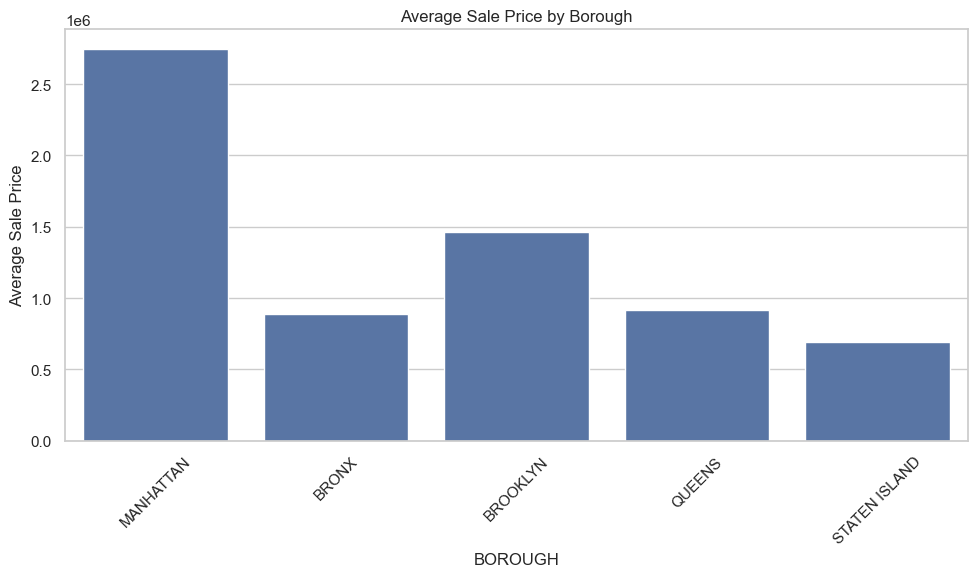

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.barplot(data=combined_df, x='BOROUGH', y='SALE PRICE', estimator='mean', ci=None)
plt.title('Average Sale Price by Borough')
plt.ylabel('Average Sale Price')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
#Renaming of neighborhood for against NTA 2020 zoning map 